In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
import requests

C:\Program Files\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import json
import argparse
import psycopg2

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras import layers, initializers
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomUniform
from array import *
import os.path
import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
import matplotlib.pyplot as plt
from math import sqrt
from sys import argv #Module for receiving parameters from the command line
import io
from PIL import Image
import base64

In [4]:
#%matplotlib qt

# Загрузка параметров

In [5]:
load_params_from_config_file = True #Загрузка параметров из файла
load_params_from_command_line = False #Загрузка параметров из командной строки
args = None

try:
    parser = argparse.ArgumentParser()
    _ = parser.add_argument('--config_file', dest='config_file', action='store_true', help='Load config from file')
    _ = parser.add_argument('--config_path', help='Path to config file: /app/cfg.json')
    _ = parser.add_argument('--cmd_config', dest='cmd_config', action='store_true', help='Load config from cmd line')
    _ = parser.add_argument('--task_id')
    _ = parser.add_argument('--data_path')
    _ = parser.add_argument('--scaler_path')
    _ = parser.add_argument('--neural_path')
    _ = parser.add_argument('--new_model_flag')
    _ = parser.add_argument('--learning_rate')
    _ = parser.add_argument('--epochs')
    _ = parser.add_argument('--steps_per_epoch')
    _ = parser.add_argument('--validation_steps')
    _ = parser.add_argument('--respos_url')
    args, unknown = parser.parse_known_args()
    
    if args.config_file:
        load_params_from_config_file = True
        load_params_from_command_line = False
    
    if args.cmd_config:
            load_params_from_config_file = False
            load_params_from_command_line = True
except:
    print("Ошибка парсинга параметров из командной строки")

In [6]:
if load_params_from_config_file:
    #Если есть параметры командной строки
    if args:
        #Если указан путь к конфигу
        if args.config_path:
            with open(config_path, 'r', encoding='utf_8') as cfg:
                temp_data=cfg.read()
        else:
            with open('app/configs/1D/edu_neural.json', 'r', encoding='utf_8') as cfg:
                temp_data=cfg.read()

    # parse file`
    config = json.loads(temp_data)
    
    task_id = str(config['task_id'])
    #Путь для загрузки генерируемых данных
    data_path = config['data_path'] #Путь должен быть без чёрточки в конце
    #Путь для сохранения скалера
    scaler_path = config['scaler_path'] #Путь должен быть без чёрточки в конце
    #Путь для сохранения нейронных сетей
    neural_path = config['neural_path'] #Путь должен быть без чёрточки в конце
    #Флаг необходимости подготовки новой модели (False - дообучение существующей)
    new_model_flag = bool(config['new_model_flag'])
    learning_rate = config['learning_rate']
    epochs = config['epochs']
    steps_per_epoch = config['steps_per_epoch']
    validation_steps = config['validation_steps']
    if config['respos_url']:
        respos_url = config['respos_url']
    else:
        respos_url = '127.0.0.1:8080'
    
if load_params_from_command_line:
    task_id = str(args.task_id)
    data_path = str(args.data_path)
    scaler_path = str(args.scaler_path)
    neural_path = str(args.neural_path) 
    new_model_flag = bool(args.new_model_flag)
    learning_rate = float(args.learning_rate) 
    epochs = int(args.epochs) 
    steps_per_epoch = int(args.steps_per_epoch) 
    validation_steps = int(args.validation_steps) 
    if args.respos_url:
        respos_url = str(args.respos_url).replace(']',"").replace('[',"").replace('"',"").replace("'","")
    else:
        respos_url = '127.0.0.1:8080'

Y_shift = 0

In [7]:
type = 'current'# Тип нейросети в ансамбле
period = '1d'

dataset_type = 'num_logic'
dataset_timeframe = '1d_1w'

#data_type_flag = False;
#data_type_flag = 'float16';
data_type_flag = 'float32';
#data_type_flag = 'float64';

#Флаг необходимости масштабирования данных
scale_flag = True



#Флаг тестирования модели
test_model_flag = False

#Флаг необходимости сохранения модели
save_model_flag = True

dataset = dataset_type + '_' + dataset_timeframe

In [8]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [9]:
#Создаём директории
try:
    print("Проверяем наличие директории скалера: ", scaler_path)
    if os.path.exists(scaler_path) == False:
        print("Создаём директорию скалера")
        os.mkdir(scaler_path)
    else:
        print("Директория скалера существует")
except:
    print("Ошибка создания директории скалера")
    
try:
    print("Проверяем наличие директории нейронной сети: ", neural_path)
    if os.path.exists(neural_path) == False:
        print("Создаём директорию нейронной сети")
        os.mkdir(neural_path)
    else:
        print("Директория нейронной сети существует")
except:
    print("Ошибка создания директории нейронной сети")

Проверяем наличие директории скалера:  app/scalers/1D
Директория скалера существует
Проверяем наличие директории нейронной сети:  app/neurals/1D
Директория нейронной сети существует


In [10]:

# Импортируем данные для обучения и тестирования
print("Импортируем данные")
if data_type_flag == 'float16':
    #init_data_train = pd.read_csv('./'+data_path+'/'+dataset+'_train.csv', dtype = 'float16', sep = ',')
    init_data_train = pd.read_csv(data_path+'/'+dataset+'_train.csv', dtype = 'float16', sep = ',')
elif data_type_flag == 'float32':
    #init_data_train = pd.read_csv('./'+data_path+'/'+dataset+'_train.csv', dtype = 'float32', sep = ',')
    init_data_train = pd.read_csv(data_path+'/'+dataset+'_train.csv', dtype = 'float32', sep = ',')
else:
    #init_data_train = pd.read_csv('./'+data_path+'/'+dataset+'_train.csv', sep = ',')
    init_data_train = pd.read_csv(data_path+'/'+dataset+'_train.csv', sep = ',')
if data_type_flag == 'float16':
    #init_data_test = pd.read_csv('./'+data_path+'/'+dataset+'_test.csv', dtype = 'float16', sep = ',')
    init_data_test = pd.read_csv(data_path+'/'+dataset+'_test.csv', dtype = 'float16', sep = ',')
elif data_type_flag == 'float32':
    #init_data_test = pd.read_csv('./'+data_path+'/'+dataset+'_test.csv', dtype = 'float32', sep = ',')
    init_data_test = pd.read_csv(data_path+'/'+dataset+'_test.csv', dtype = 'float32', sep = ',')
else:
    init_data_test = pd.read_csv('./app/data/'+dataset+'_test.csv', sep = ',')
print("Доля NaN данных в датасете train:", init_data_train.isna().sum() / init_data_train.shape[0]*100)
print("Доля NaN данных в датасете test:", init_data_test.isna().sum() / init_data_test.shape[0]*100)

#Исключаем nan и inf
init_data_train.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
init_data_test.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Устанавливаем размерность датасетов
n_train = init_data_train.shape[0]
p_train = init_data_train.shape[1]
print("Число факторов: ", p_train)
n_test = init_data_test.shape[0]
p_test = init_data_test.shape[1]
# Формируем данные в numpy-массив
init_data_train = init_data_train.values
init_data_test = init_data_test.values
# Подготовка данных для обучения и тестирования (проверки)
print("Подготавливаем обучающие, тестовые и предиктивные выборки")
train_start = 0
train_end = n_train
test_start = 0
test_end = n_test
data_train = init_data_train[np.arange(train_start, train_end), :]
data_test = init_data_test[np.arange(test_start, test_end), :]
#Выбор данных
print("Выбираем данные")
trainX = data_train[:, 3:]
trainY = data_train[:, 2]
train_quotes_close = data_train[:, 1]
testX = data_test[:, 3:]
testY = data_test[:, 2]
test_quotes_close = data_test[:, 1]
# Масштабирование данных
print("Масштабируем данные")
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
if scale_flag: 
    x_scaler.fit(trainX)
    #scaler_filename = './'+scaler_path+'/scaler_'+dataset+'.save'
    scaler_filename = scaler_path+'/scaler_'+dataset+'.save'
    joblib.dump(x_scaler, scaler_filename) 
#Изменяем размерность массива, для обеспечения возможности масштабирования Y
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)
train_quotes_close = train_quotes_close.reshape(-1, 1)
test_quotes_close = test_quotes_close.reshape(-1, 1)
if scale_flag:
    #y_scaler.fit(trainY)
    trainX = x_scaler.transform(trainX)
    testX = x_scaler.transform(testX)
#Изменяем размерность массива Х, для рекурентной нейросети
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Импортируем данные
Доля NaN данных в датасете train: Datetime     0.0
Close        0.0
Y            0.0
Open:5m      0.0
High:5m      0.0
            ... 
gap_14:5m    0.0
gap_16:5m    0.0
gap_18:5m    0.0
gap_20:5m    0.0
gap_40:5m    0.0
Length: 2662, dtype: float64
Доля NaN данных в датасете test: Datetime     0.0
Close        0.0
Y            0.0
Open:5m      0.0
High:5m      0.0
            ... 
gap_14:5m    0.0
gap_16:5m    0.0
gap_18:5m    0.0
gap_20:5m    0.0
gap_40:5m    0.0
Length: 2662, dtype: float64
Число факторов:  2662
Подготавливаем обучающие, тестовые и предиктивные выборки
Выбираем данные
Масштабируем данные


In [11]:
#Проверяем число анализируемых факторов
print("Число анализируемых факторов", trainX.shape[2])
print("Число анализируемых данных тренировочной выборки", trainX.shape[0])
print("Число анализируемых данных тестовой выборки", testX.shape[0])

Число анализируемых факторов 2659
Число анализируемых данных тренировочной выборки 3554
Число анализируемых данных тестовой выборки 395


In [12]:
def plt_to_png(graph):
    buffer = io.BytesIO()
    graph.savefig(buffer, format='png')
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    graphic = base64.b64encode(image_png)
    graphic = graphic.decode('utf-8')
    graph.close()

    return graphic

In [13]:
factors_count = trainX.shape[2]
data_count = trainX.shape[0]

In [14]:
def data_train():
    while True:
        x = trainX
        y = trainY
        yield (x,y)

In [15]:
def data_test():
    while True:
        x = testX
        y = testY
        yield (x,y)

In [16]:
def tfdata_generator(x_datas, y_datas, is_training, batch_size=128):
    '''Construct a data generator using `tf.Dataset`. '''

    def map_fn(x_data, y_data):
        '''Preprocess raw data to trainable input. '''
        x = x_data 
        y = y_data
        return x, y

    dataset = tf.data.Dataset.from_tensor_slices((x_datas, y_datas))
    
    if is_training:
        dataset = dataset.shuffle(1000)  # depends on sample size
        dataset = dataset.map(map_fn)
        dataset = dataset.batch(batch_size)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [17]:
training_set = tfdata_generator(trainX, trainY,is_training=True)

train_generator = data_train()
valid_generator = data_test()

In [18]:
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
from datetime import datetime

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [21]:
#Проверяем существование нейронной сети
#file_path = './'+neural_path+'/ansamble_'+dataset+'_v1.h5'
file_path = neural_path+'/ansamble_'+dataset+'_v1.h5'

In [22]:
#Тестируем нейронную сеть
if (os.access(file_path, os.F_OK) == True) & (test_model_flag == True):
    print("Тестируем нейронную сеть")
    #Загружаем нейронную сеть
    print("Загружаем сеть")
    #model = load_model('./'+neural_path+'/ansamble_'+dataset+'_v1.h5');
    model = load_model(neural_path+'/ansamble_'+dataset+'_v1.h5');

In [23]:
#Дообучаем нейроннуюю сеть
if (os.access(file_path, os.F_OK) == True) & (test_model_flag == False) & (new_model_flag == False):
    print("Дообучаем нейронную сеть")
    #Загружаем нейронную сеть
    print("Загружаем сеть")
    #model = load_model('./'+neural_path+'/ansamble_'+dataset+'_v1.h5');
    model = load_model(neural_path+'/ansamble_'+dataset+'_v1.h5');
    
    #Обучаем нейронную сеть
    print("Обучаем нейронную сеть")
    his = model.fit(
        training_set, 
        validation_data=valid_generator, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch, 
        validation_steps = validation_steps, 
        callbacks=[
            #model_checkpoint_callback,
            #es
        ]
    )
    
    if save_model_flag == True:    
        #Сохраняем нейронную сеть
        print("Сохраняем нейронную сеть")
        #model.save('./'+neural_path+'/ansamble_'+dataset+'_v1.h5')
        model.save(neural_path+'/ansamble_'+dataset+'_v1.h5')

In [24]:
if ((os.access(file_path, os.F_OK) == False) | (new_model_flag == True)) & (test_model_flag == False) :
    print("Нейронная сеть Отсутствует")
    # define and fit the final model
    print("Формируем модель нейросети")
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(trainX.shape[1], trainX.shape[2])))
    
    #num_logic start
    if dataset_type == 'num_logic':
        model.add(Dense(
            1000,
            activation='relu', 
            kernel_regularizer=regularizers.l2(0.001),
            kernel_initializer='random_normal',
            bias_initializer='zeros'
        ))   
        model.add(Dense(
            500,
            activation='relu', 
            kernel_regularizer=regularizers.l2(0.001),
            kernel_initializer='random_normal',
            bias_initializer='zeros'
        ))
        model.add(Dense(
            units=250, 
            #125,
            activation='tanh', 
            kernel_regularizer=regularizers.l2(0.001),
            kernel_initializer='random_normal',
            bias_initializer='zeros'
        ))
        model.add(Dense(
            units=150, 
            #75,
            activation='relu', 
            kernel_regularizer=regularizers.l2(0.001),
            kernel_initializer='random_normal',
            bias_initializer='zeros'
        ))
    #num_logic end

    model.add(Dense(
        3, 
        kernel_regularizer=regularizers.l2(0.01),
        kernel_initializer='random_normal',
        bias_initializer='zeros',
        activation='softmax'
    ))

    opt =  keras.optimizers.Adam(clipvalue=1., clipnorm=1., learning_rate = learning_rate,amsgrad = True)
    print("Компилируем нейронную сеть")
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	   
    
    #Обучаем нейронную сеть
    print("Обучаем нейронную сеть")
    his = model.fit(
        training_set, 
        validation_data=valid_generator, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch, 
        validation_steps = validation_steps, 
        callbacks=[
            #model_checkpoint_ca|llback,
            #es
            #tensorboard_callback
        ]
    )

    if save_model_flag == True:    
        #Сохраняем нейронную сеть
        print("Сохраняем нейронную сеть")
        #model.save('./'+neural_path+'/ansamble_'+dataset+'_v1.h5')
        model.save(neural_path+'/ansamble_'+dataset+'_v1.h5')

Нейронная сеть Отсутствует
Формируем модель нейросети
Компилируем нейронную сеть
Обучаем нейронную сеть
Epoch 1/10
128/128 [==============================] - 5s 38ms/step - loss: 9.3213 - accuracy: 0.4179 - val_loss: 9.2514 - val_accuracy: 0.4025
Epoch 2/10
128/128 [==============================] - 5s 35ms/step - loss: 9.1538 - accuracy: 0.4578 - val_loss: 9.0871 - val_accuracy: 0.4557
Epoch 3/10
128/128 [==============================] - 5s 37ms/step - loss: 8.9981 - accuracy: 0.4859 - val_loss: 8.9381 - val_accuracy: 0.4937
Epoch 4/10
128/128 [==============================] - 5s 35ms/step - loss: 8.8509 - accuracy: 0.5045 - val_loss: 8.8006 - val_accuracy: 0.5089
Epoch 5/10
128/128 [==============================] - 4s 35ms/step - loss: 8.7096 - accuracy: 0.5172 - val_loss: 8.6665 - val_accuracy: 0.5114
Epoch 6/10
128/128 [==============================] - 5s 35ms/step - loss: 8.5741 - accuracy: 0.5339 - val_loss: 8.5528 - val_accuracy: 0.5063
Epoch 7/10
128/128 [==================

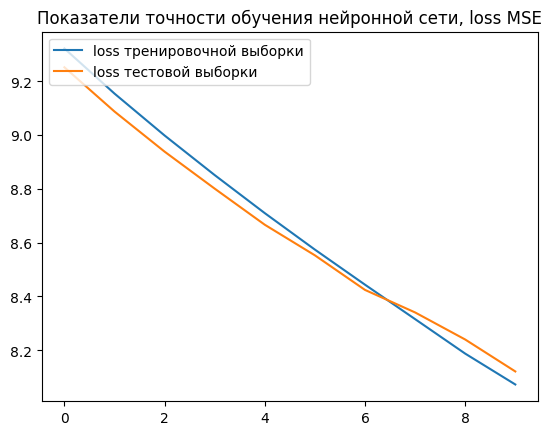

In [25]:
try:
    if is_notebook():
        #Наблюдаем показатели точности
        fig, ax = plt.subplots()
        ax.set_title('Показатели точности обучения нейронной сети, loss MSE')
        plt.plot(his.history['loss'], label='loss тренировочной выборки')
        plt.plot(his.history['val_loss'], label='loss тестовой выборки')
        plt.legend(loc="upper left")
        plt.show()
except:
    pass

In [26]:
print("Предсказываем результат")
predict_testY = model.predict(testX, verbose = 1)
predict_trainY = model.predict(trainX, verbose = 1)

Предсказываем результат
112/112 [==============================] - 0s 4ms/step


In [27]:
#Преобразовываем выходные сигналы тренировочной выборки
result_predict_trainY = []

for predict in predict_trainY:
    result_predict_trainY.append(np.argmax(predict))
        
result_predict_trainY = np.array(result_predict_trainY)

In [28]:
#Преобразовываем выходные сигналы тестовой выборки
result_predict_testY = []

for predict in predict_testY:
    result_predict_testY.append(np.argmax(predict))
        
result_predict_testY = np.array(result_predict_testY)

# Расчёт трендов

In [29]:
#Расчёт трендов для тренировочной выборки на основе сигналов по разметке
last_train_signal = 2
train_trends_origin = array('f', []) #Массив ожидаемых данных по тренду
for i in range(trainY.shape[0]):
    if trainY[i] != last_train_signal and (trainY[i] == 2 or trainY[i] == 0):
        last_train_signal = trainY[i]
    train_trends_origin.insert(i,last_train_signal)

C:\Users\Adimin\AppData\Local\Temp\ipykernel_144944\3911187962.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_trends_origin.insert(i,last_train_signal)


In [30]:
#Расчёт трендов для тестовой выборки на основе расчётных сигналов
last_test_signal = 2
test_trends_origin = array('f', []) #Массив ожидаемых данных по тренду
for i in range(testY.shape[0]):
    if testY[i] != last_test_signal and (testY[i] == 2 or testY[i] == 0):
        last_test_signal = testY[i]
    test_trends_origin.insert(i,last_test_signal)

C:\Users\Adimin\AppData\Local\Temp\ipykernel_144944\3764835393.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_trends_origin.insert(i,last_test_signal)


In [31]:
#Расчёт трендов для тренировочной выборки на основе расчётных данных
last_train_signal = 2
train_trends_predict = array('f', []) #Массив ожидаемых данных по тренду
for i in range(len(result_predict_trainY)):
    if result_predict_trainY[i] != last_train_signal and (result_predict_trainY[i] == 2 or result_predict_trainY[i] == 0):
        last_train_signal = result_predict_trainY[i]
    train_trends_predict.insert(i,last_train_signal)

In [32]:
#Расчёт трендов для тестовой выборки на основе расчётных сигналов
last_test_signal = 2
test_trends_predict = array('f', []) #Массив ожидаемых данных по тренду
for i in range(len(result_predict_testY)):
    if result_predict_testY[i] != last_test_signal and (result_predict_testY[i] == 2 or result_predict_testY[i] == 0):
        last_test_signal = result_predict_testY[i]
    test_trends_predict.insert(i,last_test_signal)

In [33]:
train_trends_origin = np.asarray(train_trends_origin).astype(int)
test_trends_origin = np.asarray(test_trends_origin).astype(int)
train_trends_predict = np.asarray(train_trends_predict).astype(int)
test_trends_predict = np.asarray(test_trends_predict).astype(int)

# Расчёт показателей точности

In [34]:
train_accuracy_score = accuracy_score(train_trends_origin, train_trends_predict)
train_roc_auc_score = roc_auc_score(train_trends_origin, train_trends_predict)
train_precision_score = precision_score(train_trends_origin, train_trends_predict, pos_label=2)
train_recall_score = recall_score(train_trends_origin, train_trends_predict, pos_label=2)
train_f1_score = f1_score(train_trends_origin, train_trends_predict, pos_label=2)
train_log_loss = log_loss(train_trends_origin, train_trends_predict)

In [35]:
#Выводим данные результатов анализа точности
print("РЕЗУЛЬТАТЫ АНАЛИЗА ТОЧНОСТИ");

print("ТРЕНИРОВОЧНАЯ ВЫБОРКА")
print('accuracy:', accuracy_score(train_trends_origin, train_trends_predict))
print('roc-auc:', roc_auc_score(train_trends_origin, train_trends_predict))
print('precision:', precision_score(train_trends_origin, train_trends_predict, pos_label=2))
print('recall:', recall_score(train_trends_origin, train_trends_predict, pos_label=2))
print('f1:', f1_score(train_trends_origin, train_trends_predict, pos_label=2))
print('logloss:', log_loss(train_trends_origin, train_trends_predict))

РЕЗУЛЬТАТЫ АНАЛИЗА ТОЧНОСТИ
ТРЕНИРОВОЧНАЯ ВЫБОРКА
accuracy: 0.7273494653911086
roc-auc: 0.7257537926970633
precision: 0.7168008048289738
recall: 0.7782632441288914
f1: 0.7462686567164178
logloss: 9.417142515481613


In [36]:
test_accuracy_score = accuracy_score(test_trends_origin, test_trends_predict)
test_roc_auc_score = roc_auc_score(test_trends_origin, test_trends_predict)
test_precision_score = precision_score(test_trends_origin, test_trends_predict, pos_label=2)
test_recall_score = recall_score(test_trends_origin, test_trends_predict, pos_label=2)
test_f1_score = f1_score(test_trends_origin, test_trends_predict, pos_label=2)
test_log_loss = log_loss(test_trends_origin, test_trends_predict)

In [37]:
print("ТЕСТОВАЯ ВЫБОРКА")
print('accuracy:', accuracy_score(test_trends_origin, test_trends_predict))
print('roc-auc:', roc_auc_score(test_trends_origin, test_trends_predict))
print('precision:', precision_score(test_trends_origin, test_trends_predict, pos_label=2))
print('recall:', recall_score(test_trends_origin, test_trends_predict, pos_label=2))
print('f1:', f1_score(test_trends_origin, test_trends_predict, pos_label=2))
print('logloss:', log_loss(test_trends_origin, test_trends_predict))

ТЕСТОВАЯ ВЫБОРКА
accuracy: 0.4911392405063291
roc-auc: 0.5486973222735623
precision: 0.7131147540983607
recall: 0.3438735177865613
f1: 0.464
logloss: 17.575498838701527


# Сохранение результатов

In [38]:
result = {
    'task_id': task_id,
    'edu_graph_losses': {
        'loss': {
            'description': 'Loss тренировочной выборки',
            'values': his.history['loss']
        },
        'val_loss': {
            'description': 'Loss валидационной выборки',
            'values': his.history['val_loss']
        }
    },
    'train_accuracy_score': {
        'description': 'Метрика точности accuracy тренировочной выборки',
        'values': float(train_accuracy_score)
    }, 
    'train_roc_auc_score': {
        'description': 'Метрика точности roc_auc тренировочной выборки',
        'values': float(train_roc_auc_score)
    }, 
    'train_precision_score': {
        'description': 'Метрика точности precision тренировочной выборки',
        'values': float(train_precision_score)
    }, 
    'train_recall_score': {
        'description': 'Метрика точности recall тренировочной выборки',
        'values': float(train_recall_score)
    }, 
    'train_f1_score': {
        'description': 'Метрика точности f1 тренировочной выборки',
        'values': float(train_f1_score)
    }, 
    'train_log_loss': {
        'description': 'Метрика точности log_loss тренировочной выборки',
        'values': float(train_log_loss)
    },
    'test_accuracy_score': {
        'description': 'Метрика точности accuracy тестовой выборки',
        'values': float(test_accuracy_score)
    }, 
    'test_roc_auc_score': {
        'description': 'Метрика точности roc_auc тестовой выборки',
        'values': float(test_roc_auc_score)
    }, 
    'test_precision_score': {
        'description': 'Метрика точности precision тестовой выборки',
        'values': float(test_precision_score)
    }, 
    'test_recall_score': {
        'description': 'Метрика точности recall тестовой выборки',
        'values': float(test_recall_score)
    }, 
    'test_f1_score': {
        'description': 'Метрика точности f1 тестовой выборки',
        'values': float(test_f1_score)
    }, 
    'test_log_loss': {
        'description': 'Метрика точности log тестовой выборки',
        'values': float(test_log_loss)
    }
}

In [39]:
# with open('results/edu_neurals.json', 'w') as f:
#     json.dump(result, f)

In [40]:
count = 0

while True:
    try:
        url = 'http://'+respos_url+'/api/v1/task/complied'
        response = requests.post(url, json = result)
        if response.status_code == 200:
            print("Запрос успешно отправлен:")
            break
    except Exception as err:
        print("Ошибка отправка запроса на API:", err)
    
    #Делаем повторные попытки в случае ошибки
    if count >= 5:
        break
        
    count += 1    

Ошибка отправка запроса на API: HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/v1/task/complied (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B4C76F0F70>: Failed to establish a new connection: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение'))
Ошибка отправка запроса на API: HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/v1/task/complied (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B4C76F0FA0>: Failed to establish a new connection: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение'))
Ошибка отправка запроса на API: HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/v1/task/complied (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B4C76F01F0>: Failed to establish a new con